In [1]:
!wget https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
!unzip "ALL-2views.zip" -d "data/"

--2025-02-05 18:08:02--  https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954873 (4.7M) [application/zip]
Saving to: ‘ALL-2views.zip’

ALL-2views.zip      100%[===================>]   4.72M  1.59MB/s    in 3.0s    

2025-02-05 18:08:10 (1.59 MB/s) - ‘ALL-2views.zip’ saved [4954873/4954873]

Archive:  ALL-2views.zip
 extracting: data/Art/disp1.png      
 extracting: data/Art/disp5.png      
  inflating: data/Art/view1.png      
  inflating: data/Art/view5.png      
 extracting: data/Books/disp1.png    
 extracting: data/Books/disp5.png    
  inflating: data/Books/view1.png    
  inflating: data/Books/view5.png    
  inflating: data/Computer/view1.png  
  inflating: data/Computer/view5.png  
  inflating: data/Dolls/disp1.png    
 

In [220]:
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

class StereoView:
    def __init__(self, folder):
        imgl = folder + "/view1.png"
        imgr = folder + "/view5.png"
        gl = folder + "/disp1.png"
        gr = folder + "/disp5.png"

        self.imgl = self._load_image(imgl)
        self.imgr = self._load_image(imgr)
        self.gl = self._load_image(gl)
        self.gr = self._load_image(gr)
        self.folder = folder
    
    @staticmethod
    def _load_image(path):
        return np.asarray(Image.open(path)) / 255

    def __repr__(self):
        return f"{self.__class__.__name__}('{self.folder}')"
    
    def unconstrained_disparity(self, window_size, similarity):
        disparity_map = np.zeros_like(self.imgl)
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2

        for i in tqdm(range(half_window, m - half_window)):
            for j in range(half_window, n - half_window):
                region1 = self.imgl[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]

                similarities = []

                for j1 in range(j, 0, -1):
                    region2 = self.imgr[i - half_window: i + half_window + 1, j1 - half_window: j1 + half_window + 1]
                    sim = similarity(region1, region2)
                    similarities.append(sim)

                best_match_index = np.argmax(similarities)
                disparity_map[i, j] = best_match_index - half_window

        disparity_map = (disparity_map - min(disparity_map.flatten())) / max(disparity_map.flatten())
        return disparity_map

    def constrained_disparity(self, window_size, similarity):
        disparity_map = np.zeros_like(self.imgl)
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2

        for i in tqdm(range(half_window, m - half_window)):
            for j in range(half_window, n - half_window):
                region1 = self.imgl[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]

                prev_hit = half_window - 1
                similarities = []

                for j1 in range(j, prev_hit, -1):
                    region2 = self.imgr[i - half_window: i + half_window + 1, j1 - half_window: j1 + half_window + 1]
                    sim = similarity(region1, region2)
                    similarities.append(sim)

                best_match_index = np.argmax(similarities)
                prev_hit = best_match_index + half_window - 1
                disparity_map[i, j] = best_match_index

        disparity_map = (disparity_map - min(disparity_map.flatten())) / max(disparity_map.flatten())
        
        return disparity_map



svs = []

for image_class in os.listdir("data/"):
  if image_class not in ["Computer", "Drumsticks", "Dwarves"]:
    svs.append(StereoView("data/" + image_class))

In [221]:
svs

[StereoView('data/Laundry'),
 StereoView('data/Art'),
 StereoView('data/Reindeer'),
 StereoView('data/Books'),
 StereoView('data/Dolls'),
 StereoView('data/Moebius')]

In [239]:
class ColorSimilarity:
  def __init__(self):
    pass

  @staticmethod
  def SSD(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    return -np.sum((patch1 - patch2) ** 2)

  @staticmethod
  def ZNCC(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"

    patch1, patch2 = patch1.astype(float), patch2.astype(float)

    zncc_sum = 0
    for c in range(patch1.shape[2]):  
      p1 = patch1[:, :, c] - patch1[:, :, c].mean()
      p2 = patch2[:, :, c] - patch2[:, :, c].mean()
      
      std1, std2 = np.std(p1), np.std(p2)
      if std1 == 0 or std2 == 0:
          continue

      zncc_sum += (p1 * p2).sum() / (std1 * std2)

    return zncc_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

  @staticmethod
  def CENSUS(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    
    diffs_sum = 0
    for c in range(patch1.shape[2]):
      n = patch1.shape[0]
      pt1 = patch1[n//2, n//2, c]
      pt2 = patch2[n//2, n//2, c]

      b1 = "".join(map(str, (patch1[:, :, c] > pt1).flatten().astype(int).tolist()))
      b2 = "".join(map(str, (patch2[:, :, c] > pt2).flatten().astype(int).tolist()))

      diffs = sum(1 for x1, x2 in zip(b1, b2) if x1 != x2)
      diffs_sum += diffs

    return -diffs_sum / patch1.shape[2] 

  @staticmethod
  def RANK(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    
    rank_corr_sum = 0
    for c in range(patch1.shape[2]): 
      p1, p2 = patch1[:, :, c].flatten(), patch2[:, :, c].flatten()
      
      rank1 = np.argsort(np.argsort(p1)) + 1
      rank2 = np.argsort(np.argsort(p2)) + 1

      rank1 = rank1.reshape(patch1.shape[:2]).astype(float)
      rank2 = rank2.reshape(patch1.shape[:2]).astype(float)

      rank1 -= rank1.mean()
      rank2 -= rank2.mean()

      std1, std2 = np.std(rank1), np.std(rank2)
      if std1 == 0 or std2 == 0:
        continue 

      rank_corr_sum += (rank1 * rank2).sum() / (std1 * std2)

    return rank_corr_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

In [223]:
dm = svs[-1].constrained_disparity(9, ColorSimilarity.SSD)

100%|██████████| 362/362 [01:40<00:00,  3.62it/s]


In [224]:
def scale_image(image):
    return (image - min(image.flatten())) / (max(image.flatten()) - min(image.flatten()))

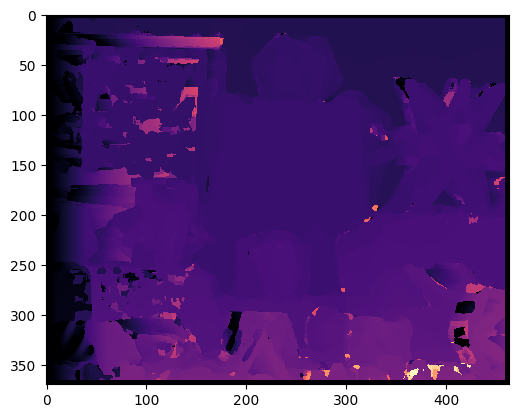

In [244]:
import matplotlib.pyplot as plt
plt.imshow(scale_image(1 - 1/(dm+.8))[..., 0], cmap='magma')

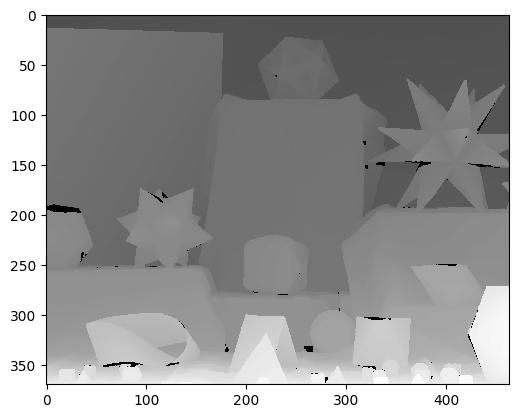

In [245]:
plt.imshow(svs[-1].gl, cmap='gray')

In [247]:
ColorSimilarity.RANK(scale_image(1 - 1/(dm+.8)), np.array([svs[-1].gl]*3).transpose(1, 2, 0))

np.float64(0.5869420570174658)